<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/fish.jpg" width="400px"></div>

# Anomaly Exploration (understanding the 1%)
In this notebook we're going to be using the BroThon Python module for processing, transformation and anomaly detection on Bro IDS data. We're going to look at 'normal' http traffic and demonstrate the use of Isolation Forests for anomaly detection. We'll then explore those anomalies with clustering and PCA.

**Software**
- BroThon: https://github.com/Kitware/BroThon
- Pandas: https://github.com/pandas-dev/pandas
- Scikit-Learn: http://scikit-learn.org/stable/index.html

**Techniques**
- One Hot Encoding: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
- Isolation Forest: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- PCA: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

<div style="float: right; margin: 20px 20px 20px 20px"><img src="https://www.kitware.com/img/small_logo_over.png"></div>

**Related Notebooks**
- BroThon Scikit-Learn: https://github.com/Kitware/BroThon/blob/master/notebooks/Bro_IDS_to_Scikit_Learn.ipynb

In [313]:
import brothon
from brothon import bro_log_reader
from brothon.analysis import dataframe_to_matrix
print('BroThon: {:s}'.format(brothon.__version__))
import pandas as pd
print('Pandas: {:s}'.format(pd.__version__))
import numpy as np
print('Numpy: {:s}'.format(np.__version__))
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
print('Scikit Learn Version:', sklearn.__version__)

BroThon: 0.2.0
Pandas: 0.19.2
Numpy: 1.12.1
Scikit Learn Version: 0.18.1


In [381]:
# Load in the Bro IDS dns logs
reader = bro_log_reader.BroLogReader('/Users/briford/data/bro/kitware/http.log')

# Create a Pandas dataframe from reader
bro_df = pd.DataFrame(reader.readrows())
print('Read in {:d} Rows...'.format(len(bro_df)))
bro_df.head()

Successfully monitoring /Users/briford/data/bro/kitware/http.log...
Read in 502826 Rows...


,filename,host,id.orig_h,id.orig_p,id.resp_h,id.resp_p,info_code,info_msg,method,orig_fuids,...,resp_mime_types,response_body_len,status_code,status_msg,tags,trans_depth,ts,uid,uri,username
0,-,guyspy.com,192.168.33.10,1031,54.245.228.191,80,-,-,GET,-,...,text/html,184,301,Moved Permanently,(empty),1,2013-09-15 17:44:27.668082,CyIaMO7IheOh38Zsi,/,-
1,-,www.guyspy.com,192.168.33.10,1032,54.245.228.191,80,-,-,GET,-,...,text/html,100631,200,OK,(empty),1,2013-09-15 17:44:27.731702,CoyZrY2g74UvMMgp4a,/,-
2,-,www.guyspy.com,192.168.33.10,1032,54.245.228.191,80,-,-,GET,-,...,text/html,55817,404,Not Found,(empty),2,2013-09-15 17:44:28.092922,CoyZrY2g74UvMMgp4a,/wp-content/plugins/slider-pro/css/advanced-sl...,-
3,-,www.guyspy.com,192.168.33.10,1040,54.245.228.191,80,-,-,GET,-,...,text/plain,887,200,OK,(empty),1,2013-09-15 17:44:28.150301,CiCKTz4e0fkYYazBS3,/wp-content/plugins/contact-form-7/includes/cs...,-
4,-,www.guyspy.com,192.168.33.10,1041,54.245.228.191,80,-,-,GET,-,...,text/plain,10068,200,OK,(empty),1,2013-09-15 17:44:28.150602,C1YBkC1uuO9bzndRvh,/wp-content/plugins/slider-pro/css/slider/adva...,-


<div style="float: left; margin: 20px -10px 0px -40px"><img src="images/confused.jpg" width="200px"></div>
<div style="float: right; margin: 20px -10px 0px -10px"><img src="images/pandas.png" width="300px"></div>
## So... what just happened?
**Yep it was quick... the two little lines of code above turned a Bro IDS log (any log) into a Pandas DataFrame. The BroThon package also supports streaming data from dynamic/active logs, handles log rotations and in general tries to make your life a bit easier when doing data analysis and machine learning on Bro data.**

**Now that we have the data in a dataframe there are a million wonderful things we could do for data munging, processing and analysis but that will have to wait for another time/notebook.**

In [315]:
# We're going to pick some features that might be interesting
# some of the features are numerical and some are categorical
features = ['id.resp_p', 'method', 'resp_mime_types', 'request_body_len']

# Convert these columns to be Category types
bro_df['method'] = bro_df['method'].astype('category')
bro_df['resp_mime_types'] = bro_df['resp_mime_types'].astype('category')

## Our HTTP features are a mix of numeric and categorical data
When we look at the http records some of the data is numerical and some of it is categorical so we'll need a way of handling both data types in a generalized way. BroThon has a DataFrameToMatrix class that handles a lot of the details and mechanics of combining numerical and categorical data, we'll use below.

In [316]:
# Show the dataframe with mixed feature types
bro_df[features].head()

,id.resp_p,method,resp_mime_types,request_body_len
0,80,GET,text/json,0
1,80,GET,text/html,0
2,80,GET,-,0
3,80,POST,text/plain,0
4,80,POST,text/plain,0


<div style="float: right; margin: -10px 40px -10px 40px"><img src="images/transformers.png" width="200px"></div>
## Transformers
**We'll now use a scikit-learn tranformer class to convert the Pandas DataFrame to a numpy ndarray (matrix). Yes it's awesome... I'm not sure it's Optimus Prime awesome.. but it's still pretty nice.**

In [317]:
# Use the BroThon DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing
# this for real we should explicitly convert before sending to the transformer.
to_matrix = dataframe_to_matrix.DataFrameToMatrix()
bro_matrix = to_matrix.fit_transform(bro_df[features], normalize=True)
print(bro_matrix.shape)
bro_matrix[:1]

(502826, 64)


array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [354]:
# Train/fit and Predict anomalous instances using the Isolation Forest model
odd_clf = IsolationForest(contamination=0.01) # Marking 1% odd
odd_clf.fit(bro_matrix)

IsolationForest(bootstrap=False, contamination=0.02, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [355]:
# Now we create a new dataframe using the prediction from our classifier
odd_df = bro_df[features][odd_clf.predict(bro_matrix) == -1]
print(odd_df.shape)
odd_df.head()

(11062, 4)


,id.resp_p,method,resp_mime_types,request_body_len
22,80,OPTIONS,application/xml,131
23,80,OPTIONS,application/xml,66
24,80,PROPFIND,application/xml,300
25,80,PROPFIND,application/xml,111
26,80,PROPFIND,application/xml,148


In [357]:
# Now we're going to explore our odd dataframe with help from KMeans and PCA algorithms
odd_matrix = to_matrix.transform(odd_df)

In [366]:
# Just some simple stuff for this example, KMeans and PCA
kmeans = KMeans(n_clusters=11).fit_predict(odd_matrix)
pca = PCA(n_components=3).fit_transform(odd_matrix)

# Now we can put our ML results back onto our dataframe!
odd_df['x'] = pca[:, 0] # PCA X Column
odd_df['y'] = pca[:, 1] # PCA Y Column
odd_df['z'] = pca[:, 2] # PCA Z Column
odd_df['cluster'] = kmeans
odd_df.head()

,id.resp_p,method,resp_mime_types,request_body_len,x,y,z,cluster,jx,jy,jz
22,80,OPTIONS,application/xml,131,-0.716568,-0.199070,0.885458,3,-0.760125,-0.242158,0.922581
23,80,OPTIONS,application/xml,66,-0.716568,-0.199070,0.885458,3,-0.663090,-0.201885,0.897558
24,80,PROPFIND,application/xml,300,-0.875596,-0.354603,-0.511068,0,-0.856910,-0.291888,-0.513927
25,80,PROPFIND,application/xml,111,-0.875596,-0.354603,-0.511068,0,-0.925124,-0.370772,-0.536067
26,80,PROPFIND,application/xml,148,-0.875596,-0.354603,-0.511068,0,-0.866062,-0.287355,-0.496709


In [367]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = 15.0, 6.0

# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

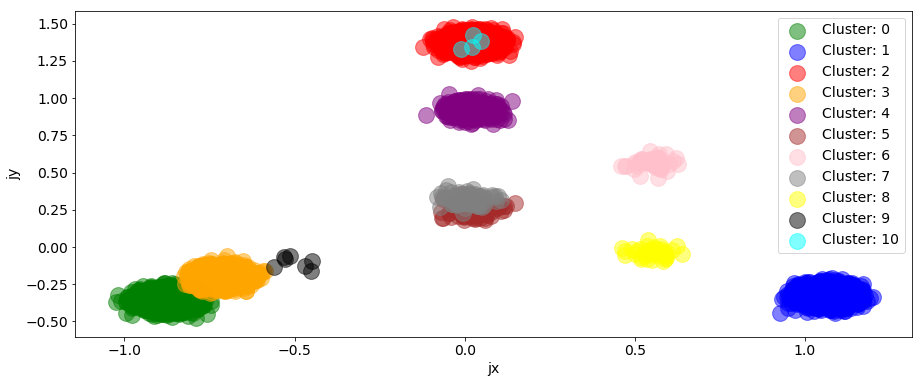

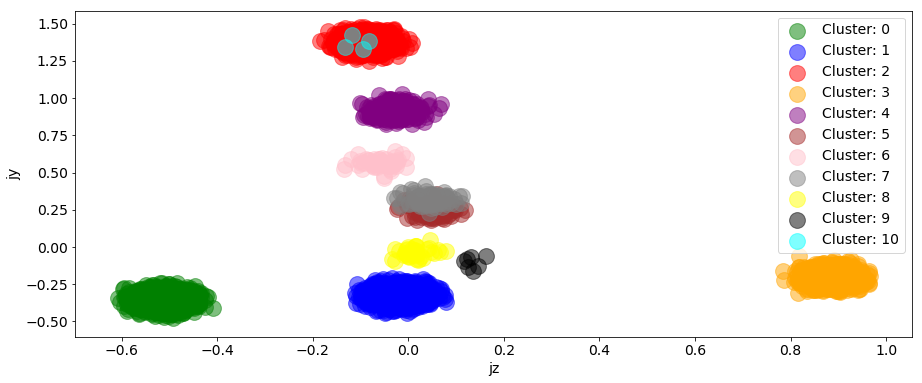

In [373]:
# Jitter so we can see instances that are projected coincident in 2D
odd_df['jx'] = jitter(odd_df['x'])
odd_df['jy'] = jitter(odd_df['y'])
odd_df['jz'] = jitter(odd_df['z'])

# Now use dataframe group by cluster
cluster_groups = odd_df.groupby('cluster')

# Plot the Machine Learning results
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown', 
          6:'pink', 7:'grey', 8:'yellow', 9:'black', 10:'cyan', 11:'magenta'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jz', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [382]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 3022 observations
     id.resp_p    method  resp_mime_types  request_body_len
24          80  PROPFIND  application/xml               300
25          80  PROPFIND  application/xml               111
26          80  PROPFIND  application/xml               148
115         80  PROPFIND  application/xml               300
117         80  PROPFIND  application/xml               111

Cluster 1: 3759 observations
     id.resp_p method resp_mime_types  request_body_len
125         80   HEAD               -                 0
212         80   HEAD               -                 0
341         80   HEAD               -                 0
443         80   HEAD               -                 0
475         80   HEAD               -                 0

Cluster 2: 1668 observations
      id.resp_p method resp_mime_types  request_body_len
1313         80    PUT      text/plain            112371
1783         80    PUT      text/plain             62913
2081         80    PUT      text/plain     

#### <div style="float: right; margin: 0px 0px 0px 0px"><img src="images/deep_dive.jpeg" width="350px"></div>
## Categorical variables that are anomalous
- HTTP Methods
- Response Ports
- Combinations of Method/Mime Types

## Numerical variable outliers: Clusters 4 and 10
- Now we'll take a deeper dive and plot the distributions for both normal and odd

In [370]:
# Need to label the entire dataset for the plot below
bro_df['label'] = ['odd' if pred==-1 else 'normal' for pred in odd_clf.predict(bro_matrix)]



- Maximum Request Body Length (NORMAL): 0.08 MB
- Maximum Request Body Length (ODD): 926.06 MB


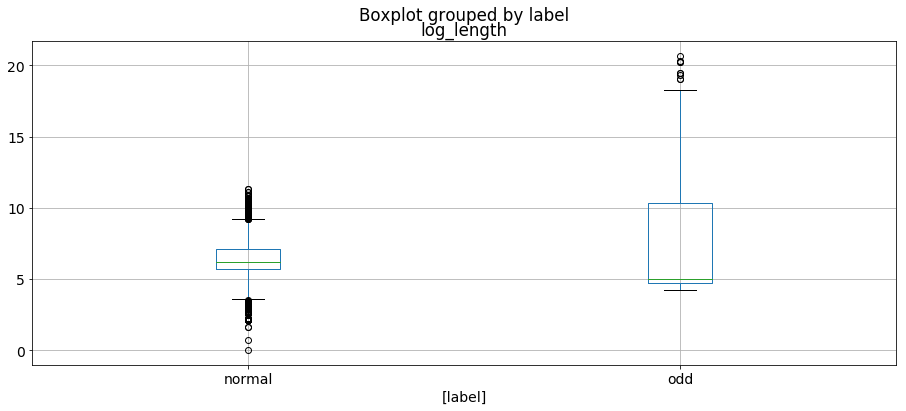

In [371]:
plot_df = bro_df[bro_df['request_body_len']!=0].copy()
plot_df['log_length'] = np.log(plot_df['request_body_len'])
plot_df[['log_length','label']].boxplot(by='label')
print('\n\n- Maximum Request Body Length (NORMAL): {:.2f} MB'.format(bro_df[bro_df['label']=='normal']['request_body_len'].max()/1024.0/1024.0))
print('- Maximum Request Body Length (ODD): {:.2f} MB'.format(bro_df[bro_df['label']=='odd']['request_body_len'].max()/1024.0/1024.0))

<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/why_normal.jpg" width="200px"></div>

## The anomalies identified by the model might be fine/expected
Looking at the anomaly clusters we can see that several of the clusters are associated with our WebDAV servers. So
here we're not equating anomalous with 'bad'. The use of an anomaly detection algorithm can bring latent issues to the attention of threat hunters and system administrations. The results might be expected or a misconfigured appliance or something more nefarious that needs attention from security.


If you liked this notebook please visit the [BroThon](https://github.com/Kitware/BroThon) project for more notebooks and examples.
<div style="float: right; margin: 20px 20px 20px 20px"><img src="https://www.kitware.com/img/small_logo_over.png"></div>